<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/EC_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EC1
**Tianbo Qiu (tq2137)**


**Implementation of a squared error loss function**

In [0]:
!pip install tf-nightly-2.0-preview

In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras

import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import relu

In [0]:
## EC1 ##

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

# Types are needed later when calculating loss
# using the ```sparse_softmax_cross_entropy_with_logits``` we chose to 
# compare against.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
BATCH_SIZE = 128
BUFFER_SIZE = len(x_train)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)



In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops

In [0]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(128)
    self.d2 = Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = relu(x)
    x = self.d2(x)
    return x 
  
model = MyModel()
optimizer = tf.keras.optimizers.Adam()

def built_in_loss(logits, labels):
  return tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)

# Mean Square Error Implementation
def our_loss(logits, labels, n_classes=10):
  labels = tf.one_hot(labels, n_classes, dtype=tf.float32)
  return K.mean(math_ops.square(labels-logits), axis=-1)

def train_on_batch(model, images, labels):
  with tf.GradientTape() as tape:
    # Forward pass
    logits = model(images)
    loss_one = built_in_loss(logits, labels)
    loss_two = our_loss(logits, labels)    
    
  # Backward pass
  # I'll use our implementation to update the gradients.
  grads = tape.gradient(loss_two, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables))
  return loss_one, loss_two

def calc_accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1)
  batch_size = int(logits.shape[0])
  acc = tf.reduce_sum(
      tf.cast(tf.equal(predictions, labels), dtype=tf.float32)) / batch_size
  return acc * 100



In [0]:
# Loop over the dataset, grab batchs, and train our model
# As we go, verify the loss returned by our implementation is
# the same as the built-in methods.

EPOCHS = 5

for epoch in range(EPOCHS):
  print("Epoch", epoch + 1, "\n")
  for (batch, (images, labels)) in enumerate(train_dataset):
    loss_one, loss_two = train_on_batch(model, images, labels)
    
    # You can use something like this as a quick sanity check
    #tf.debugging.assert_near(loss_one, loss_two, atol=0.001, rtol=0.001)
    #print("loss1",loss_one.shape, K.mean(loss_one))
    #print("loss2",loss_two.shape, K.mean(loss_two))
    step = optimizer.iterations.numpy() 
    if step % 100 == 0:
      print("Step", step)
      print("Built-in loss: {} MSE: {}".format(K.mean(loss_one),K.mean(loss_two)))
      print("")
      
  print('Train accuracy %.2f' % calc_accuracy(model(x_train), y_train))
  print('Test accuracy %.2f\n' % calc_accuracy(model(x_test), y_test))

Epoch 1 

Step 200
Built-in loss: 1.6683100461959839 MSE: 0.023214392364025116

Step 300
Built-in loss: 1.6642494201660156 MSE: 0.02293778955936432

Step 400
Built-in loss: 1.643017292022705 MSE: 0.01974768191576004

Step 500
Built-in loss: 1.6161428689956665 MSE: 0.01742279902100563

Train accuracy 94.98
Test accuracy 94.87

Epoch 2 

Step 600
Built-in loss: 1.610154390335083 MSE: 0.015985924750566483

Step 700
Built-in loss: 1.5701311826705933 MSE: 0.014738786965608597

Step 800
Built-in loss: 1.5795440673828125 MSE: 0.014546427875757217

Step 900
Built-in loss: 1.5902549028396606 MSE: 0.014589463360607624

Step 1000
Built-in loss: 1.590810775756836 MSE: 0.0164126455783844

Train accuracy 96.28
Test accuracy 95.85

Epoch 3 

Step 1100
Built-in loss: 1.5799155235290527 MSE: 0.01332764606922865

Step 1200
Built-in loss: 1.5705146789550781 MSE: 0.011924189515411854

Step 1300
Built-in loss: 1.5632209777832031 MSE: 0.01144436001777649

Step 1400
Built-in loss: 1.6118595600128174 MSE: 0.0

When the mean spuare loss decreases over iterations, the cross entropy loss decreases very slow. Using MSE is like to treat the process as a regression problem rather than a classification problem.

#EC2

**build custom a Dense layer**

In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import relu


class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs
    
  def build(self, input_shape):
    self.kernel = self.add_variable("kernel", shape=[int(input_shape[-1]),
                                                    self.num_outputs])
  def call(self, input):
    return tf.matmul(input, self.kernel)


class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = MyDenseLayer(128)
    self.d2 = MyDenseLayer(10)
  
  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = relu(x)
    return self.d2(x)
  
class MyModel2(Model):
  def __init__(self):
    super(MyModel2, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(128)
    self.d2 = Dense(10)
  
  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = relu(x)
    return self.d2(x)

  
def loss_function(logits, labels):
  return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=labels))

def train_on_batch(model, images, labels):
  with tf.GradientTape() as tape:
    # forward pass
    logits = model(images)
    loss = loss_function(logits, labels)
    # backward pass
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss # loss.shape == (batch_size, )

def acc(logits, labels):
  predictions = tf.argmax(logits, axis=1)
  batch_size = int(logits.shape[0])
  accuracy = tf.reduce_sum(tf.cast(tf.equal(predictions, labels), dtype=tf.float32)) / batch_size
  return accuracy * 100



  

In [0]:
# Data

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

# Types are needed later when calculating loss
# using the ```sparse_softmax_cross_entropy_with_logits``` we chose to 
# compare against.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
BATCH_SIZE = 128
BUFFER_SIZE = len(x_train)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


In [0]:
# Build the model

model = MyModel()
optimizer = tf.keras.optimizers.Adam()

# Training
EPOCHS = 5

for epoch in range(EPOCHS):
  print("Epoch {}: ".format(epoch+1))
  for (batch, (images, labels)) in enumerate(train_dataset):
    loss = train_on_batch(model, images, labels)
    step = optimizer.iterations.numpy()
    if step % 100 == 0:
      print("\tstep {}, loss: {}".format(step, loss))
 

Epoch 1: 
	step 100, loss: 0.29075515270233154
	step 200, loss: 0.3028695583343506
	step 300, loss: 0.2816504240036011
	step 400, loss: 0.20934338867664337
Epoch 2: 
	step 500, loss: 0.17968139052391052
	step 600, loss: 0.1882302314043045
	step 700, loss: 0.2294468879699707
	step 800, loss: 0.17239172756671906
	step 900, loss: 0.09766191989183426
Epoch 3: 
	step 1000, loss: 0.07699155807495117
	step 1100, loss: 0.061417948454618454
	step 1200, loss: 0.08709728717803955
	step 1300, loss: 0.07212940603494644
	step 1400, loss: 0.11893992125988007
Epoch 4: 
	step 1500, loss: 0.09180206060409546
	step 1600, loss: 0.12146177887916565
	step 1700, loss: 0.08273693919181824
	step 1800, loss: 0.1405399888753891
Epoch 5: 
	step 1900, loss: 0.1556229293346405
	step 2000, loss: 0.06317076832056046
	step 2100, loss: 0.0340818352997303
	step 2200, loss: 0.034171249717473984
	step 2300, loss: 0.06998111307621002


**The accuracy of the model with custom Dense layers:**

In [0]:
acc_train = acc(model(x_train), y_train).numpy()
acc_test = acc(model(x_test), y_test).numpy()
print("Training accuracy {:.2f}%".format(acc_train))
print("Test accuracy {:.2f}%".format(acc_test))


Training accuracy 98.25%
Test accuracy 97.34%


**Compare with the built-in Dense layer:**

In [0]:
model = MyModel2()
optimizer = tf.keras.optimizers.Adam()

# Training
EPOCHS = 5

for epoch in range(EPOCHS):
  print("Epoch {}: ".format(epoch+1))
  for (batch, (images, labels)) in enumerate(train_dataset):
    loss = train_on_batch(model, images, labels)
    step = optimizer.iterations.numpy()
    if step % 100 == 0:
      print("\tstep {}, loss: {}".format(step, loss))

Epoch 1: 
	step 100, loss: 0.29868853092193604
	step 200, loss: 0.2922200560569763
	step 300, loss: 0.3114679455757141
	step 400, loss: 0.23006120324134827
Epoch 2: 
	step 500, loss: 0.17613588273525238
	step 600, loss: 0.20570310950279236
	step 700, loss: 0.22828125953674316
	step 800, loss: 0.17891307175159454
	step 900, loss: 0.11106482148170471
Epoch 3: 
	step 1000, loss: 0.06547005474567413
	step 1100, loss: 0.06462503969669342
	step 1200, loss: 0.06065888702869415
	step 1300, loss: 0.07133311033248901
	step 1400, loss: 0.1238957867026329
Epoch 4: 
	step 1500, loss: 0.10380642116069794
	step 1600, loss: 0.09752555191516876
	step 1700, loss: 0.061460547149181366
	step 1800, loss: 0.1436004638671875
Epoch 5: 
	step 1900, loss: 0.13483811914920807
	step 2000, loss: 0.06568463146686554
	step 2100, loss: 0.03509753942489624
	step 2200, loss: 0.05325585603713989
	step 2300, loss: 0.05194795876741409


In [0]:
acc_train = acc(model(x_train), y_train).numpy()
acc_test = acc(model(x_test), y_test).numpy()
print("Training accuracy {:.2f}%".format(acc_train))
print("Test accuracy {:.2f}%".format(acc_test))

Training accuracy 98.28%
Test accuracy 97.29%


The results we got from the model with custom Dense layes are quite close to the results of the model with built-in Dense layers.

#EC3
**Visualize the learned weights**

In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import relu


class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs
    
  def build(self, input_shape):
    self.kernel = self.add_variable("kernel", shape=[int(input_shape[-1]),
                                                    self.num_outputs])
  def call(self, input):
    return tf.matmul(input, self.kernel)


  
class LinearModel(Model):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(10)
  
  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

  
def loss_function(logits, labels):
  return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=labels))

def train_on_batch(model, images, labels):
  with tf.GradientTape() as tape:
    # forward pass
    logits = model(images)
    loss = loss_function(logits, labels)
    # backward pass
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss # loss.shape == (batch_size, )

def acc(logits, labels):
  predictions = tf.argmax(logits, axis=1)
  batch_size = int(logits.shape[0])
  accuracy = tf.reduce_sum(tf.cast(tf.equal(predictions, labels), dtype=tf.float32)) / batch_size
  return accuracy * 100

In [0]:
# Data

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

# Types are needed later when calculating loss
# using the ```sparse_softmax_cross_entropy_with_logits``` we chose to 
# compare against.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
BATCH_SIZE = 128
BUFFER_SIZE = len(x_train)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


In [0]:
# Build the model

model = LinearModel()
optimizer = tf.keras.optimizers.Adam()

# Training
EPOCHS = 5

for epoch in range(EPOCHS):
  print("Epoch {}: ".format(epoch+1))
  for (batch, (images, labels)) in enumerate(train_dataset):
    loss = train_on_batch(model, images, labels)
    step = optimizer.iterations.numpy()
    if step % 100 == 0:
      print("\tstep {}, loss: {}".format(step, loss))
      
# Evaluate the accuracy
acc_train = acc(model(x_train), y_train).numpy()
acc_test = acc(model(x_test), y_test).numpy()
print("Training accuracy {:.2f}%".format(acc_train))
print("Test accuracy {:.2f}%".format(acc_test))

Epoch 1: 
	step 100, loss: 0.700469970703125
	step 200, loss: 0.48443537950515747
	step 300, loss: 0.4830249845981598
	step 400, loss: 0.5100744962692261
Epoch 2: 
	step 500, loss: 0.3706343173980713
	step 600, loss: 0.4496977925300598
	step 700, loss: 0.3888683617115021
	step 800, loss: 0.321163147687912
	step 900, loss: 0.4519423246383667
Epoch 3: 
	step 1000, loss: 0.3210635781288147
	step 1100, loss: 0.3143695890903473
	step 1200, loss: 0.3409484624862671
	step 1300, loss: 0.2608964741230011
	step 1400, loss: 0.2510177493095398
Epoch 4: 
	step 1500, loss: 0.26136043667793274
	step 1600, loss: 0.2401823103427887
	step 1700, loss: 0.32246333360671997
	step 1800, loss: 0.24122348427772522
Epoch 5: 
	step 1900, loss: 0.3222772181034088
	step 2000, loss: 0.5795612335205078
	step 2100, loss: 0.2911803126335144
	step 2200, loss: 0.22673040628433228
	step 2300, loss: 0.30454862117767334
Training accuracy 92.10%
Test accuracy 92.27%


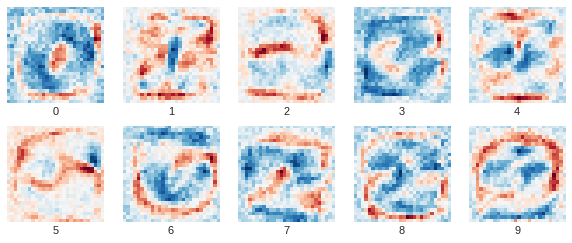

In [0]:
# Visualize the learned weights
import matplotlib.pyplot as plt

weights = model.d1.kernel
weights = weights.numpy().transpose()
num_rows = 2
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(weights[i].reshape(28,28), cmap='RdBu')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel(i)
plt.show()
